In [1]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *
from MPRA_predict.metrics import *

In [2]:
MPRA_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_Sei_feature_0529_norm.csv')
MPRA_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF,SK-N-SH_DNase,SK-N-SH_H3K4me3,SK-N-SH_H3K27ac,SK-N-SH_H3K27me3,SK-N-SH_H3K4me1,SK-N-SH_H3K36me3,SK-N-SH_H3K9me3,SK-N-SH_CTCF,HCT116_DNase,HCT116_H3K4me3,HCT116_H3K27ac,HCT116_H3K27me3,HCT116_H3K4me1,HCT116_H3K36me3,HCT116_H3K9me3,HCT116_CTCF,A549_DNase,A549_H3K4me3,A549_H3K27ac,A549_H3K27me3,A549_H3K4me1,A549_H3K36me3,A549_H3K9me3,A549_CTCF
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.014,-0.054,0.012,NaN,-0.719,1.390,2.062,1.980,1.975,1.896,1.928,1.882,1.568,1.227,1.828,1.575,2.338,1.326,2.126,NaN,1.335,1.136,1.808,1.173,2.097,NaN,1.748,NaN,1.230,0.887,1.954,1.554,1.663,1.130,2.058,NaN,1.344,1.077,2.016,1.678,NaN,1.378,NaN,2.238,1.398
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-1.042,0.183,0.094,NaN,-0.250,1.411,2.094,1.990,2.005,1.902,1.947,1.916,1.545,1.233,1.853,1.580,2.326,1.287,2.111,NaN,1.302,1.203,1.905,1.257,2.096,NaN,1.731,NaN,1.225,0.892,1.990,1.585,1.758,1.171,2.085,NaN,1.316,1.081,2.076,1.723,NaN,1.399,NaN,2.277,1.375
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-1.004,0.640,-0.188,NaN,0.685,0.425,0.468,0.103,0.818,0.243,0.401,-0.257,0.243,1.233,1.237,1.110,0.390,1.633,-0.085,NaN,0.645,-0.110,1.016,1.521,0.093,NaN,0.667,NaN,0.481,1.145,0.696,0.963,0.973,1.262,0.080,NaN,0.440,1.584,1.169,0.821,NaN,1.323,NaN,-0.209,0.514
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.779,0.751,0.274,NaN,0.737,0.535,0.650,0.311,1.004,0.355,0.423,-0.260,0.293,1.239,1.420,1.261,0.485,1.719,-0.043,NaN,0.644,0.063,1.342,1.911,0.083,NaN,0.660,NaN,0.581,1.136,0.829,1.091,1.118,1.327,-0.002,NaN,0.463,1.607,1.408,1.054,NaN,1.488,NaN,-0.181,0.539
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.457,-0.645,0.061,NaN,-0.147,-0.905,-0.808,-0.649,-0.051,-0.960,-1.142,-1.254,-0.986,-0.986,-0.688,-0.744,-0.454,-0.600,-1.121,NaN,-1.136,-1.086,-0.706,-0.376,-0.965,NaN,-1.311,NaN,-1.033,-0.986,-0.944,-0.738,-0.269,-0.997,-1.182,NaN,-0.956,-1.133,-0.800,-0.735,NaN,-0.756,NaN,-1.374,-1.089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760674,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,NaN,NaN,NaN,OL15,OL15,0.708,1.294,1.077,NaN,NaN,2.340,2.772,2.077,2.699,2.173,2.724,2.559,1.704,2.190,2.655,1.838,2.159,1.572,2.181,NaN,1.503,3.214,3.521,2.520,2.442,NaN,1.579,NaN,2.171,2.152,3.157,2.291,3.047,1.898,2.714,NaN,1.411,2.389,3.121,2.806,NaN,2.094,NaN,2.726,1.675
760675,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,NaN,NaN,NaN,OL15,OL15,-0.708,-0.547,-0.429,NaN,NaN,-0.442,-0.692,-0.653,-0.289,-0.518,-0.454,-0.900,-0.701,-0.476,-0.811,-0.623,-0.503,-0.229,-0.569,NaN,-0.662,0.435,-0.592,-0.613,-0.740,NaN,-0.422,NaN,-0.401,-0.583,-0.885,-0.778,-0.403,-0.969,-0.667,NaN,-0.700,-0.395,-0.853,-0.732,NaN,-0.705,NaN,-0.555,-0.637
760676,TGTTCAAGTGGCCACAGGGTTACTTGCTTTAGCATGGCTCCTTGGC...,Y:21740884:NA:NA,chrY,21740884,NaN,NaN,NaN,OL15,OL15,-0.146,-0.200,-0.310,NaN,NaN,0.026,-0.156,0.190,0.085,0.238,0.346,-0.599,-0.131,0.557,0.220,0.750,-0.166,1.155,-0.130,NaN,0.258,0.585,0.190,1.309,-0.005,NaN,0.694,NaN,0.312,0.870,0.181,0.972,-0.029,1.078,-0.083,NaN,0.099,1.263,0.912,1.407,NaN,1.855,NaN,0.355,0.310
760677,TAATTAGTTGGGAAGGTTCAGGTTCTGGGACATCCGTTGCTATTTC...,Y:21741084:NA:NA,chrY,21741084,NaN,NaN,NaN,OL15,OL15,-0.119,-0.090,-0.387,NaN,NaN,0.131,-0.177,-0.151,

In [3]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

In [4]:
data_split_dict = {}
data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)

data_split_dict['chrom'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(1, 23)) + ['X', 'Y'])])
data_split_dict['designed'] = ~data_split_dict['chrom']

data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(3, 23)) + ['X', 'Y'])])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test'] = MPRA_df['chr'].isin(['chr2'])

data_split_dict['ref'] = (MPRA_df['allele'] == 'ref') | (MPRA_df['allele'].isna())
data_split_dict['alt'] = MPRA_df['allele'] == 'alt'

data_split_dict['high'] = MPRA_df[cell_types].mean(axis=1) > 1


# 计算每条序列在不同细胞类型中的最大值和最小值之差
MPRA_df['range'] = MPRA_df[cell_types].max(axis=1, skipna=True) - MPRA_df[cell_types].min(axis=1, skipna=True)
# 计算 range 的第95百分位
threshold = np.percentile(MPRA_df['range'].dropna(), 95)
# 前5%的高差值序列为 diff，其余为 const
data_split_dict['diff'] = MPRA_df['range'] > threshold
data_split_dict['const'] = ~data_split_dict['diff']


for key in data_split_dict:
    print(key, data_split_dict[key].sum())

keys = list(data_split_dict.keys())
for k1 in keys:
    for k2 in keys:
        data_split_dict[f'{k1}+{k2}'] = data_split_dict[k1] & data_split_dict[k2]

total 760679
chrom 760679
designed 0
train 631073
valid 70952
test 58654
ref 389266
alt 371413
high 78990
diff 38034
const 722645


In [5]:
for j, assay in enumerate(assays):
    pearson_df = pd.DataFrame(dtype=float)
    for i, cell_type in enumerate(cell_types):
        for k, cell_type_2 in enumerate(cell_types):
            df = MPRA_df
            x = df[f'{cell_type}_{assay}']
            y = df[f'{cell_type_2}_{assay}']
            r, _ = pearson(x, y)
            pearson_df.loc[f'{cell_type}_{assay}', f'{cell_type_2}_{assay}'] = r
    print(pearson_df)

               K562_DNase  HepG2_DNase  SK-N-SH_DNase  HCT116_DNase  A549_DNase
K562_DNase          1.000        0.875          0.811         0.889       0.896
HepG2_DNase         0.875        1.000          0.836         0.887       0.912
SK-N-SH_DNase       0.811        0.836          1.000         0.775       0.787
HCT116_DNase        0.889        0.887          0.775         1.000       0.952
A549_DNase          0.896        0.912          0.787         0.952       1.000
                 K562_H3K4me3  HepG2_H3K4me3  SK-N-SH_H3K4me3  HCT116_H3K4me3  A549_H3K4me3
K562_H3K4me3            1.000          0.938            0.914           0.937         0.912
HepG2_H3K4me3           0.938          1.000            0.895           0.942         0.942
SK-N-SH_H3K4me3         0.914          0.895            1.000           0.921         0.942
HCT116_H3K4me3          0.937          0.942            0.921           1.000         0.957
A549_H3K4me3            0.912          0.942            0.94

In [6]:
for i, cell_type in enumerate(cell_types):
    pearson_df = pd.DataFrame(dtype=float)
    for j, assay in enumerate(assays):
        for k, assay_2 in enumerate(assays):
            df = MPRA_df
            x = df[f'{cell_type}_{assay}']
            y = df[f'{cell_type}_{assay_2}']
            r, _ = pearson(x, y)
            pearson_df.loc[f'{cell_type}_{assay}', f'{cell_type}_{assay_2}'] = r
    print(pearson_df)

              K562_DNase  K562_H3K4me3  K562_H3K27ac  K562_CTCF
K562_DNase         1.000         0.924         0.922      0.856
K562_H3K4me3       0.924         1.000         0.965      0.799
K562_H3K27ac       0.922         0.965         1.000      0.751
K562_CTCF          0.856         0.799         0.751      1.000
               HepG2_DNase  HepG2_H3K4me3  HepG2_H3K27ac  HepG2_CTCF
HepG2_DNase          1.000          0.916          0.916       0.889
HepG2_H3K4me3        0.916          1.000          0.956       0.792
HepG2_H3K27ac        0.916          0.956          1.000       0.756
HepG2_CTCF           0.889          0.792          0.756       1.000
                 SK-N-SH_DNase  SK-N-SH_H3K4me3  SK-N-SH_H3K27ac  SK-N-SH_CTCF
SK-N-SH_DNase            1.000            0.800            0.711         0.856
SK-N-SH_H3K4me3          0.800            1.000            0.836         0.766
SK-N-SH_H3K27ac          0.711            0.836            1.000         0.645
SK-N-SH_CTCF       

In [21]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

for cell_type in cell_types:
    df = MPRA_df.copy()


    X = df[[f'{cell_type}_DNase']].values
    y_ctcf = df[f'{cell_type}_CTCF'].values
    y_act  = df[f'{cell_type}'].values

    lin = LinearRegression().fit(X, y_ctcf)
    r_ctcf = y_ctcf - lin.predict(X)

    lin = LinearRegression().fit(X, y_act)
    r_act  = y_act  - lin.predict(X)

    rho, p = pearsonr(r_ctcf, r_act)
    print(cell_type, "partial corr (CTCF, Activity | DNase) =", rho, "p=", p)

K562 partial corr (CTCF, Activity | DNase) = -0.13239315495119802 p= 0.0
HepG2 partial corr (CTCF, Activity | DNase) = -0.11484568818100148 p= 0.0
SK-N-SH partial corr (CTCF, Activity | DNase) = -0.00862055893137643 p= 5.5318167737871214e-14


ValueError: Input y contains NaN.

=== K562 ===
   bin  DNase H3K4me3 H3K27ac   CTCF
0    0 -0.055  -0.040   0.025 -0.047
1    1 -0.015   0.030   0.094 -0.044
2    2 -0.001   0.019   0.083 -0.043
3    3 -0.007   0.025   0.081 -0.059
4    4 -0.012   0.033   0.080 -0.074
5    5  0.001   0.032   0.072 -0.083
6    6  0.005   0.018   0.054 -0.098
7    7  0.007   0.017   0.057 -0.103
8    8  0.010   0.011   0.051 -0.103
9    9  0.007  -0.008   0.036 -0.124
10  10  0.011  -0.009   0.032 -0.126
11  11  0.012  -0.023   0.022 -0.127
12  12  0.012  -0.030   0.010 -0.131
13  13  0.030  -0.047  -0.003 -0.128
14  14  0.021  -0.065  -0.025 -0.140
15  15  0.049  -0.067  -0.023 -0.150
16  16  0.057  -0.080  -0.044 -0.146
17  17  0.075  -0.089  -0.048 -0.167
18  18  0.151  -0.029  -0.018 -0.155
19  19  0.451   0.306   0.212 -0.098


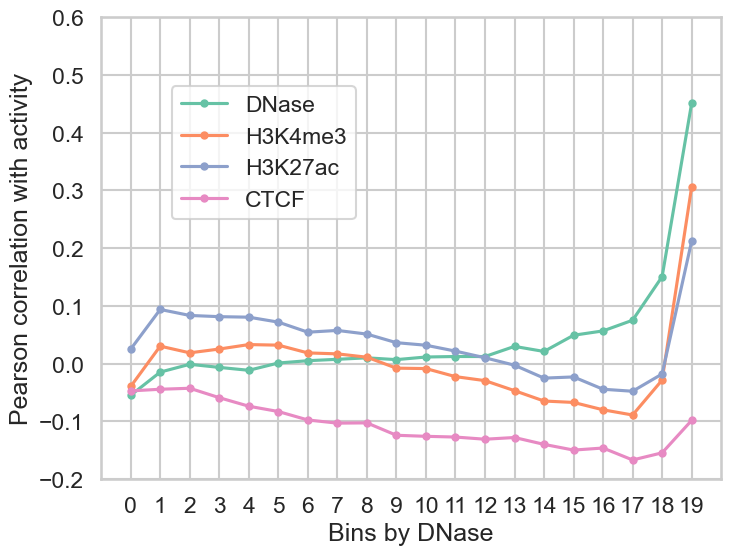

=== HepG2 ===
   bin  DNase H3K4me3 H3K27ac   CTCF
0    0 -0.008   0.086  -0.018 -0.096
1    1 -0.015   0.153   0.064 -0.041
2    2 -0.009   0.166   0.087 -0.015
3    3  0.005   0.178   0.096 -0.005
4    4  0.000   0.184   0.105  0.006
5    5 -0.002   0.188   0.111 -0.003
6    6  0.003   0.199   0.110 -0.005
7    7  0.006   0.197   0.112 -0.030
8    8  0.014   0.208   0.114 -0.022
9    9  0.004   0.207   0.116 -0.035
10  10  0.011   0.204   0.106 -0.040
11  11  0.014   0.194   0.103 -0.062
12  12  0.021   0.196   0.107 -0.066
13  13  0.024   0.184   0.091 -0.075
14  14  0.035   0.193   0.095 -0.088
15  15  0.027   0.170   0.066 -0.097
16  16  0.061   0.157   0.058 -0.095
17  17  0.077   0.148   0.034 -0.109
18  18  0.127   0.190   0.016 -0.105
19  19  0.287   0.285   0.140 -0.108


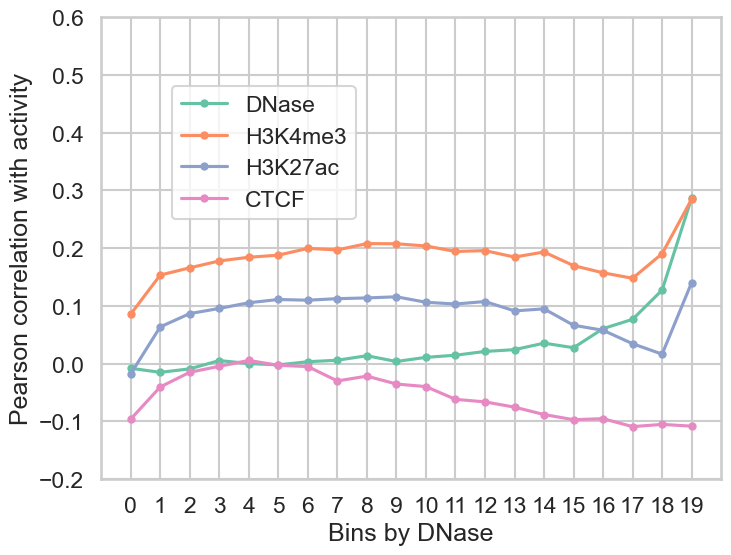

=== SK-N-SH ===
   bin  DNase H3K4me3 H3K27ac   CTCF
0    0 -0.015   0.135   0.148 -0.011
1    1  0.008   0.131   0.164 -0.039
2    2 -0.001   0.119   0.150 -0.062
3    3  0.001   0.134   0.167 -0.048
4    4 -0.001   0.128   0.171 -0.043
5    5 -0.011   0.142   0.189 -0.025
6    6  0.007   0.171   0.215 -0.009
7    7 -0.001   0.180   0.224 -0.009
8    8  0.012   0.204   0.245  0.022
9    9  0.011   0.228   0.263  0.028
10  10  0.013   0.246   0.280  0.046
11  11  0.011   0.258   0.292  0.037
12  12  0.013   0.268   0.305  0.054
13  13  0.021   0.284   0.321  0.062
14  14  0.029   0.299   0.325  0.067
15  15  0.029   0.307   0.338  0.064
16  16  0.023   0.332   0.364  0.058
17  17  0.057   0.336   0.375  0.057
18  18  0.093   0.354   0.383  0.032
19  19  0.421   0.457   0.443 -0.021


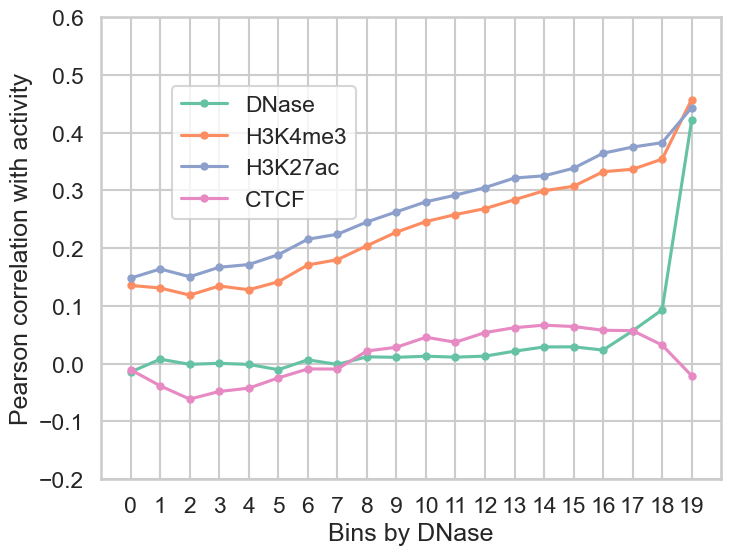

=== HCT116 ===
   bin  DNase H3K4me3 H3K27ac   CTCF
0    0 -0.072   0.025   0.127  0.004
1    1 -0.014   0.101   0.174  0.033
2    2 -0.016   0.106   0.170  0.033
3    3  0.002   0.117   0.166  0.022
4    4 -0.006   0.131   0.174  0.027
5    5 -0.003   0.142   0.167  0.024
6    6 -0.004   0.149   0.183  0.021
7    7 -0.017   0.176   0.198  0.025
8    8  0.004   0.186   0.210  0.024
9    9  0.006   0.176   0.203  0.026
10  10  0.002   0.157   0.202  0.012
11  11  0.002   0.174   0.215  0.008
12  12  0.005   0.176   0.222  0.005
13  13  0.027   0.180   0.231  0.009
14  14  0.023   0.195   0.224  0.016
15  15  0.040   0.187   0.214 -0.004
16  16  0.051   0.201   0.213 -0.011
17  17  0.076   0.223   0.213 -0.038
18  18  0.140   0.293   0.235 -0.082
19  19  0.190   0.415   0.270 -0.134


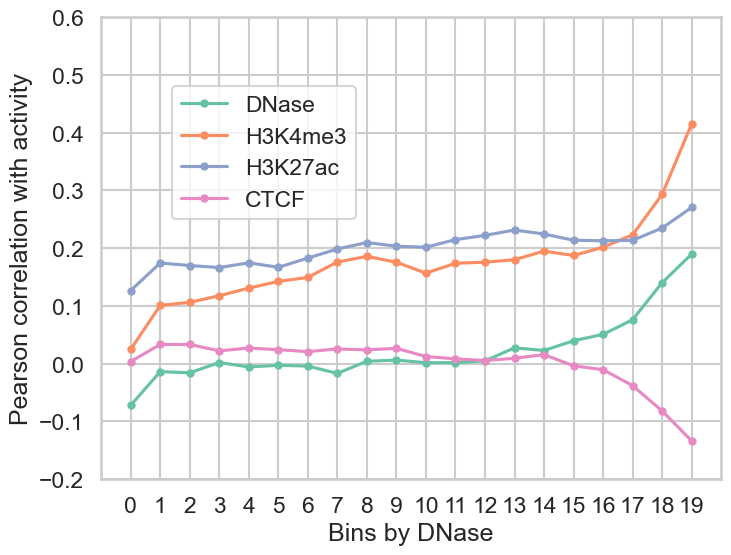

=== A549 ===
   bin  DNase H3K4me3 H3K27ac   CTCF
0    0 -0.117   0.000  -0.097 -0.107
1    1 -0.005   0.099  -0.011 -0.004
2    2 -0.022   0.111   0.023  0.016
3    3 -0.006   0.125   0.048  0.014
4    4 -0.003   0.137   0.073  0.006
5    5 -0.000   0.141   0.082  0.001
6    6  0.002   0.131   0.070 -0.017
7    7  0.001   0.160   0.108 -0.031
8    8 -0.006   0.161   0.131 -0.035
9    9  0.022   0.130   0.116 -0.053
10  10  0.007   0.118   0.116 -0.059
11  11  0.018   0.118   0.134 -0.066
12  12 -0.001   0.124   0.136 -0.078
13  13  0.022   0.110   0.126 -0.093
14  14  0.028   0.112   0.128 -0.090
15  15  0.036   0.090   0.119 -0.113
16  16  0.046   0.092   0.100 -0.125
17  17  0.066   0.087   0.085 -0.134
18  18  0.110   0.116   0.093 -0.132
19  19  0.304   0.293   0.266 -0.081


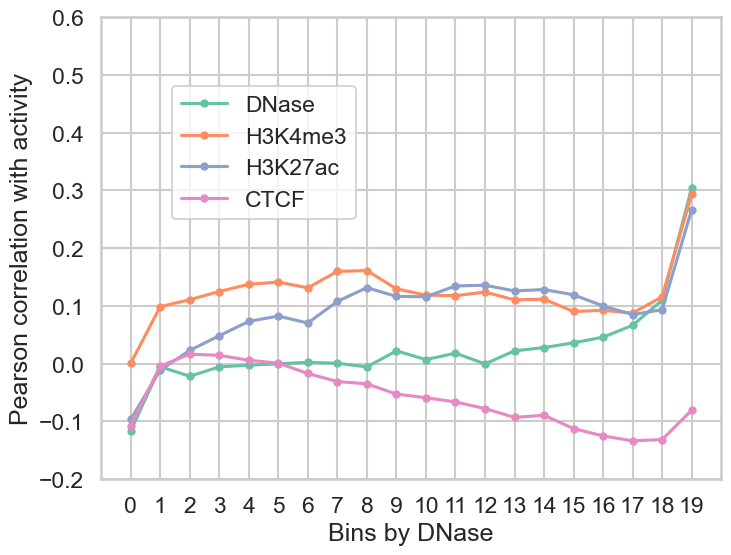

In [20]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

n_bins = 20

for cell_type in cell_types[:]:
    df = MPRA_df.copy()
    
    df['bin'] = pd.qcut(df[f'{cell_type}_DNase'], q=n_bins, labels=False)

    pearson_per_bin = pd.DataFrame(index=np.arange(n_bins), columns=['bin', 'DNase', 'H3K4me3', 'H3K27ac', 'CTCF'])

    for i in range(n_bins):
        bin_df = df[df['bin'] == i]

        x = bin_df[f'{cell_type}_DNase']
        y = bin_df[f'{cell_type}']
        r1 = pearson(x, y)[0]

        x = bin_df[f'{cell_type}_H3K4me3']
        y = bin_df[f'{cell_type}']
        r2 = pearson(x, y)[0]

        x = bin_df[f'{cell_type}_H3K27ac']
        y = bin_df[f'{cell_type}']
        r3 = pearson(x, y)[0]

        x = bin_df[f'{cell_type}_CTCF']
        y = bin_df[f'{cell_type}']
        r4 = pearson(x, y)[0]

        pearson_per_bin.loc[i] = [i, r1, r2, r3, r4]

    print(f'=== {cell_type} ===')
    print(pearson_per_bin)

    sns.set_theme(context='talk', style="whitegrid")
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

    for i, assay in enumerate(assays):
        # plt.plot(np.arange(n_bins), pearson_df[assay], marker='o', label=assays[i], color=tab20_colors[i*2+1])
        plt.plot(np.arange(n_bins), pearson_per_bin[assay], marker='o', label=assays[i], color=set2_colors[i], markersize=5)


    plt.xlabel('Bins by DNase')
    plt.ylabel('Pearson correlation with activity')
    plt.xlim(-1, n_bins)
    plt.ylim(-0.2, 0.6)
    plt.xticks(np.arange(n_bins), np.arange(n_bins))

    plt.legend(bbox_to_anchor=(1, 0.5), bbox_transform=ax.transData, loc="upper left")
    plt.savefig(f'figures/Gosai_MPRA_Sei_DNase_bin_{cell_type}.png', dpi=400, bbox_inches='tight')
    plt.savefig(f'figures_pdf/Gosai_MPRA_Sei_DNase_bin_{cell_type}.pdf', bbox_inches='tight')
    plt.show()

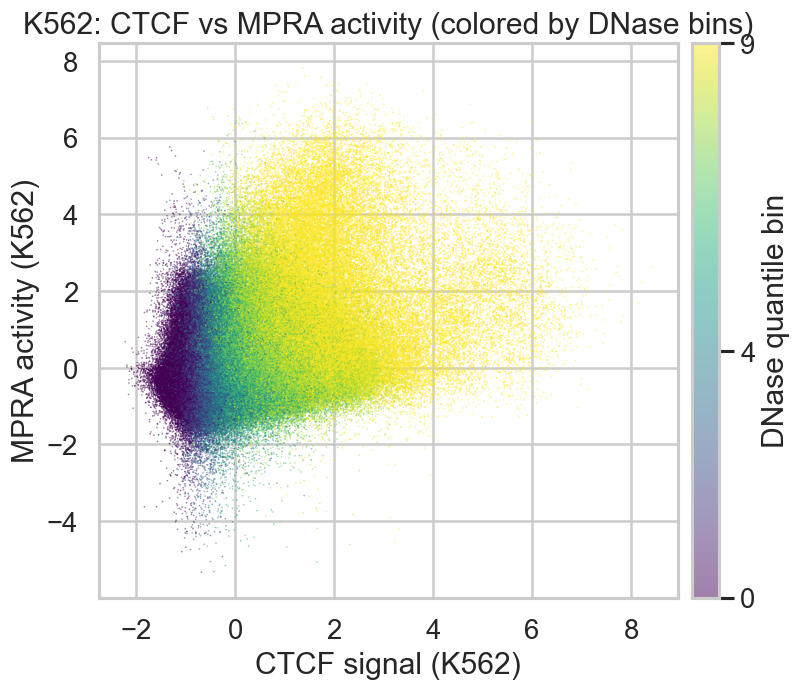

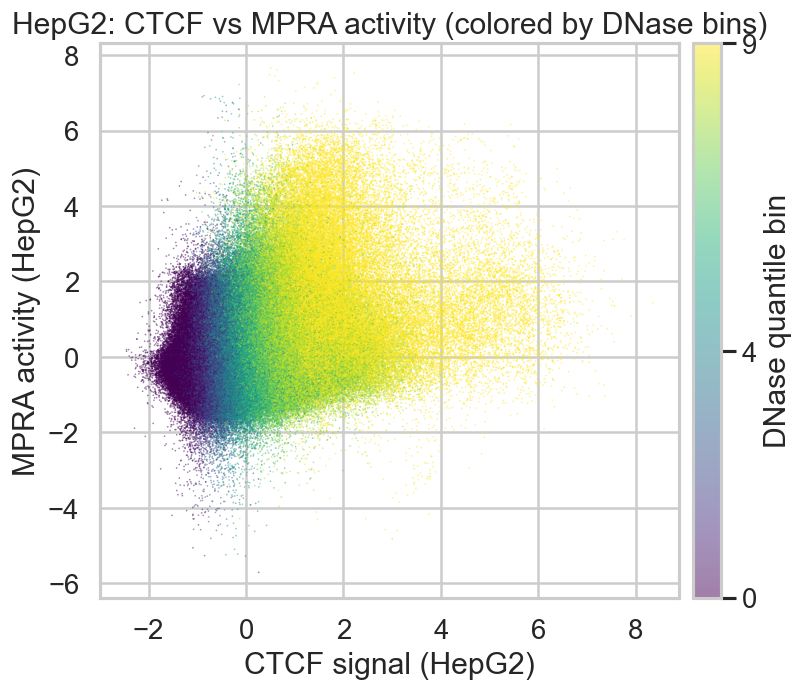

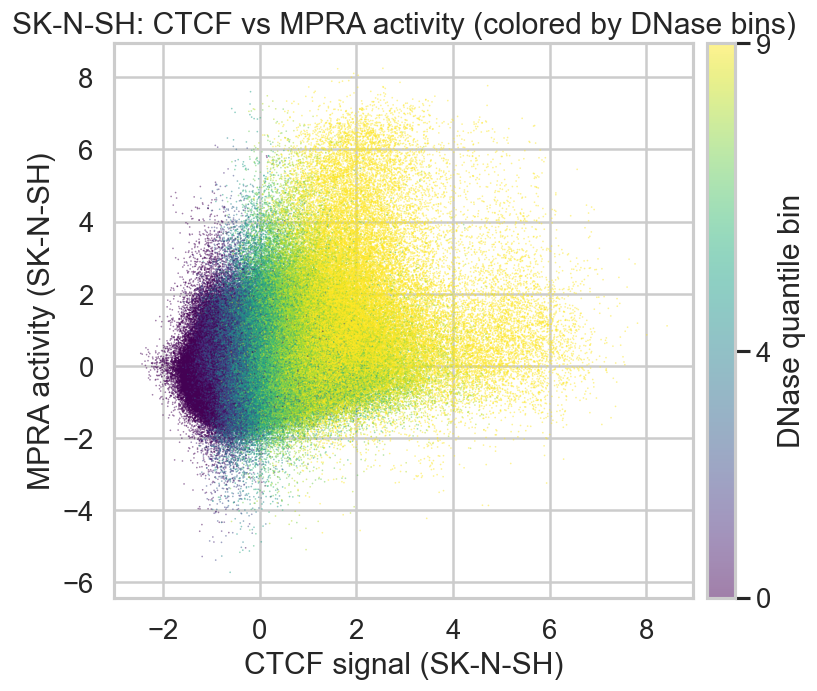

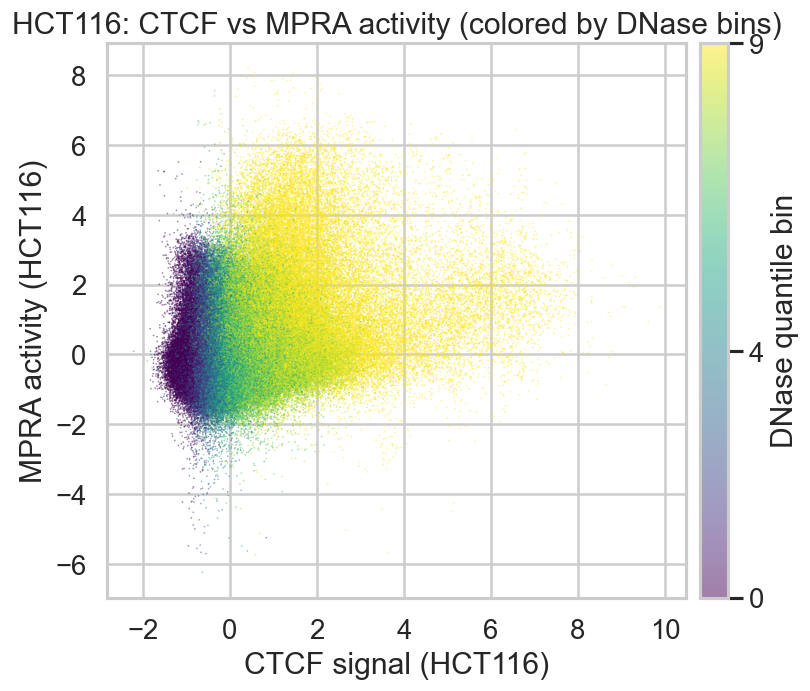

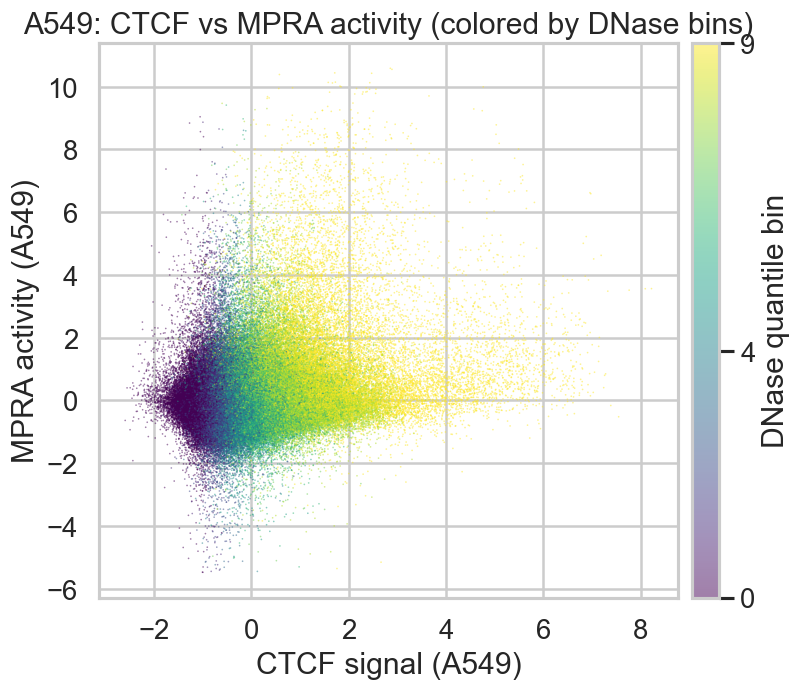

In [13]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

n_bins = 10

for cell_type in cell_types:
    df = MPRA_df.copy()
    
    df['bin'] = pd.qcut(df[f'{cell_type}_DNase'], q=n_bins, labels=False)

    cmap_name = 'viridis'  # 渐变色盘（可换 'plasma'、'cividis' 等）

    x = df[f'{cell_type}_{assay}']
    y = df[f'{cell_type}']
    c = df['bin']  # 用 DNase 的 bin 作为颜色
    bin_min = df['bin'].min()
    bin_max = df['bin'].max()

    fig, ax = plt.subplots(figsize=(7.5, 6), dpi=120)
    sc = ax.scatter(
        x, y,
        c=c,
        cmap=cmap_name,
        vmin=bin_min, vmax=bin_max,
        s=1, alpha=0.5, linewidths=0, edgecolors='none'
    )

    # 轴与标题
    ax.set_xlabel(f'{assay} signal ({cell_type})')
    ax.set_ylabel(f'MPRA activity ({cell_type})')
    ax.set_title(f'{cell_type}: {assay} vs MPRA activity (colored by DNase bins)')

    # 渐变色标注 bin
    cbar = plt.colorbar(sc, ax=ax, pad=0.02)
    cbar.set_label('DNase quantile bin')

    ticks = np.linspace(bin_min, bin_max, num=3, dtype=int)
    cbar.set_ticks(ticks)

In [22]:
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm  # 可选：用对数色标更好看

In [23]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

n_bins = 10

for cell_type in cell_types:
    df = MPRA_df.copy()
    
    df['bin'] = pd.qcut(df[f'{cell_type}_DNase'], q=n_bins, labels=False)

    cmap_name = 'viridis'  # 渐变色盘（可换 'plasma'、'cividis' 等）

    x = df[f'{cell_type}_{assay}']
    y = df[f'{cell_type}']
    c = df['bin']  # 用 DNase 的 bin 作为颜色
    bin_min = df['bin'].min()
    bin_max = df['bin'].max()

    fig, ax = plt.subplots(figsize=(7.5, 6), dpi=120)

    # 1) 取数据并去掉缺失
    x = df[f'{cell_type}_{assay}'].astype(float)
    y = df[f'{cell_type}'].astype(float)
    c = df['bin']
    mask = x.notna() & y.notna() & c.notna()
    x, y, c = x[mask].values, y[mask].values, c[mask].values

    bin_min, bin_max = int(c.min()), int(c.max())

    # 2) 计算 2D KDE（背景）
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, bw_method='scott')  # 可改 'silverman' 或数值(如0.3)微调平滑度

    # 为 KDE 建网格（用分位数裁剪极端值，避免网格太大）
    x_lo, x_hi = np.percentile(x, [1, 99])
    y_lo, y_hi = np.percentile(y, [1, 99])
    pad_x = 0.05 * (x_hi - x_lo) if x_hi > x_lo else 1.0
    pad_y = 0.05 * (y_hi - y_lo) if y_hi > y_lo else 1.0
    x_lo, x_hi = x_lo - pad_x, x_hi + pad_x
    y_lo, y_hi = y_lo - pad_y, y_hi + pad_y

    xi, yi = np.mgrid[x_lo:x_hi:200j, y_lo:y_hi:200j]
    coords = np.vstack([xi.ravel(), yi.ravel()])
    zi = kde(coords).reshape(xi.shape)

    # 3) 画 KDE 背景（建议用灰度或与散点不同的色盘）
    bg_cmap = 'Greys'        # 你也可以试 'magma_r' / 'cividis'
    bg = ax.imshow(
        zi.T,
        origin='lower',
        extent=[x_lo, x_hi, y_lo, y_hi],
        cmap=bg_cmap,
        # norm=LogNorm(vmin=max(zi.min(), 1e-8), vmax=zi.max()),  # 若密度差距大可启用
        alpha=0.9,
        aspect='auto',
        zorder=0
    )

    # KDE 的 colorbar（密度）
    cbar_kde = plt.colorbar(bg, ax=ax, pad=0.02)
    cbar_kde.set_label('KDE density')

    # 4) 叠加散点（按 DNase bin 上色）
    sc = ax.scatter(
        x, y,
        c=c,
        cmap='viridis',          # 仍用你的渐变色盘给 bin 上色
        vmin=bin_min, vmax=bin_max,
        s=3, alpha=0.4,
        linewidths=0,
        edgecolors='none',
        zorder=1
    )

    # bin 的 colorbar（分组）
    cbar_bin = plt.colorbar(sc, ax=ax, pad=0.02)
    cbar_bin.set_label('DNase quantile bin')
    ticks = np.linspace(bin_min, bin_max, num=3, dtype=int)
    cbar_bin.set_ticks(ticks)

    # 轴与标题
    ax.set_xlabel(f'{assay} signal ({cell_type})')
    ax.set_ylabel(f'MPRA activity ({cell_type})')
    ax.set_title(f'{cell_type}: {assay} vs MPRA activity\n(KDE background + points colored by DNase bins)')


=== K562 ===
    bin  DNase  H3K4me3  H3K27ac   CTCF
0     0 -0.055   -0.040    0.025 -0.047
1     1 -0.015    0.030    0.094 -0.044
2     2 -0.001    0.019    0.083 -0.043
3     3 -0.007    0.025    0.081 -0.059
4     4 -0.012    0.033    0.080 -0.074
5     5  0.001    0.032    0.072 -0.083
6     6  0.005    0.018    0.054 -0.098
7     7  0.007    0.017    0.057 -0.103
8     8  0.010    0.011    0.051 -0.103
9     9  0.007   -0.008    0.036 -0.124
10   10  0.011   -0.009    0.032 -0.126
11   11  0.012   -0.023    0.022 -0.127
12   12  0.012   -0.030    0.010 -0.131
13   13  0.030   -0.047   -0.003 -0.128
14   14  0.021   -0.065   -0.025 -0.140
15   15  0.049   -0.067   -0.023 -0.150
16   16  0.057   -0.080   -0.044 -0.146
17   17  0.075   -0.089   -0.048 -0.167
18   18  0.151   -0.029   -0.018 -0.155
19   19  0.451    0.306    0.212 -0.098


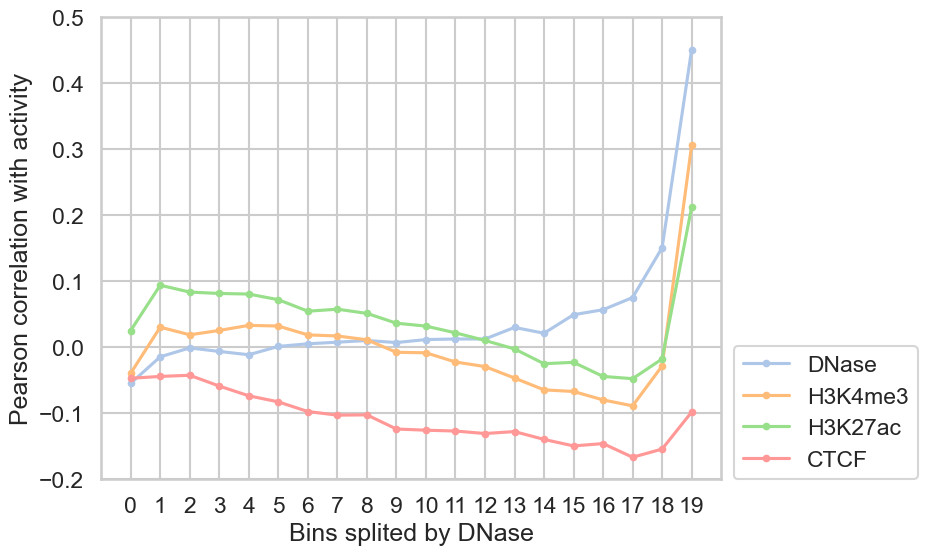

=== HepG2 ===
    bin  DNase  H3K4me3  H3K27ac   CTCF
0     0 -0.008    0.086   -0.018 -0.096
1     1 -0.015    0.153    0.064 -0.041
2     2 -0.009    0.166    0.087 -0.015
3     3  0.005    0.178    0.096 -0.005
4     4  0.000    0.184    0.105  0.006
5     5 -0.002    0.188    0.111 -0.003
6     6  0.003    0.199    0.110 -0.005
7     7  0.006    0.197    0.112 -0.030
8     8  0.014    0.208    0.114 -0.022
9     9  0.004    0.207    0.116 -0.035
10   10  0.011    0.204    0.106 -0.040
11   11  0.014    0.194    0.103 -0.062
12   12  0.021    0.196    0.107 -0.066
13   13  0.024    0.184    0.091 -0.075
14   14  0.035    0.193    0.095 -0.088
15   15  0.027    0.170    0.066 -0.097
16   16  0.061    0.157    0.058 -0.095
17   17  0.077    0.148    0.034 -0.109
18   18  0.127    0.190    0.016 -0.105
19   19  0.287    0.285    0.140 -0.108


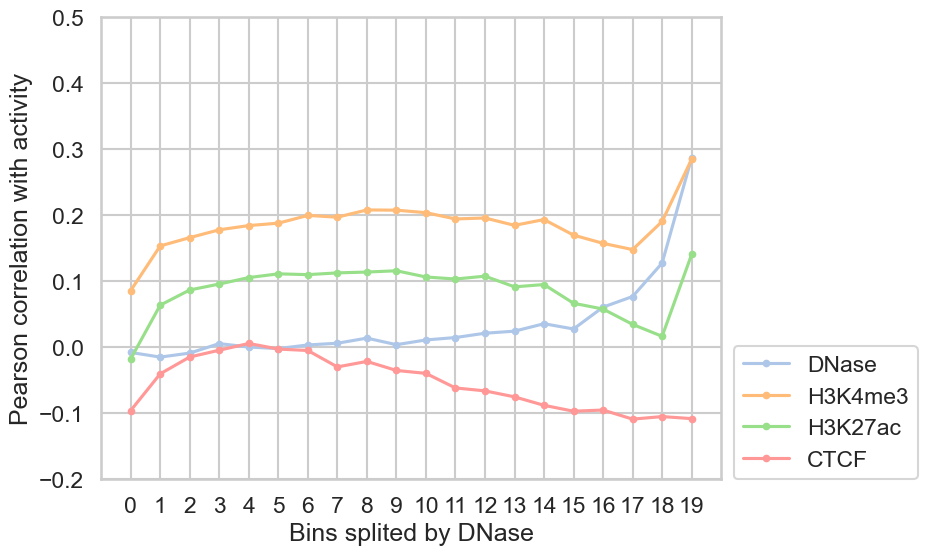

=== SK-N-SH ===
    bin  DNase  H3K4me3  H3K27ac   CTCF
0     0 -0.015    0.135    0.148 -0.011
1     1  0.008    0.131    0.164 -0.039
2     2 -0.001    0.119    0.150 -0.062
3     3  0.001    0.134    0.167 -0.048
4     4 -0.001    0.128    0.171 -0.043
5     5 -0.011    0.142    0.189 -0.025
6     6  0.007    0.171    0.215 -0.009
7     7 -0.001    0.180    0.224 -0.009
8     8  0.012    0.204    0.245  0.022
9     9  0.011    0.228    0.263  0.028
10   10  0.013    0.246    0.280  0.046
11   11  0.011    0.258    0.292  0.037
12   12  0.013    0.268    0.305  0.054
13   13  0.021    0.284    0.321  0.062
14   14  0.029    0.299    0.325  0.067
15   15  0.029    0.307    0.338  0.064
16   16  0.023    0.332    0.364  0.058
17   17  0.057    0.336    0.375  0.057
18   18  0.093    0.354    0.383  0.032
19   19  0.421    0.457    0.443 -0.021


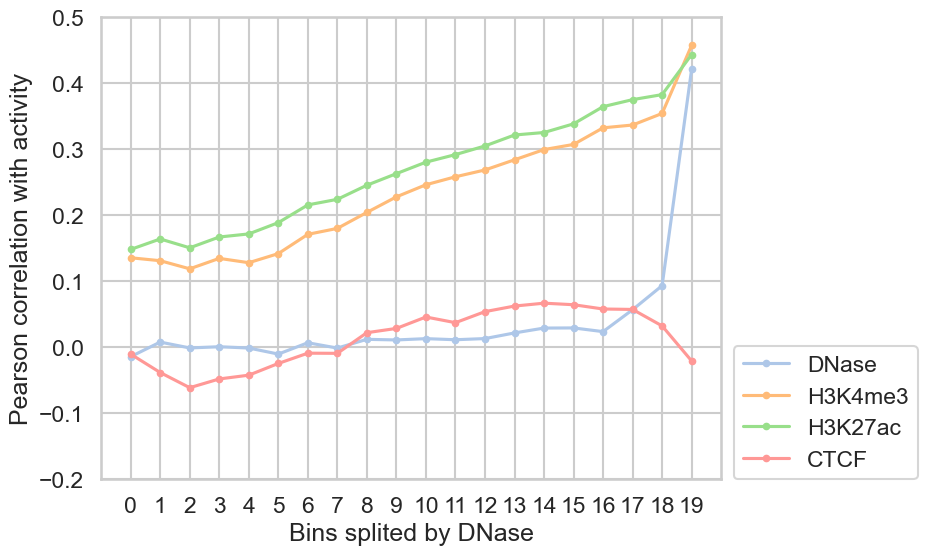

=== HCT116 ===
    bin  DNase  H3K4me3  H3K27ac   CTCF
0     0 -0.072    0.025    0.127  0.004
1     1 -0.014    0.101    0.174  0.033
2     2 -0.016    0.106    0.170  0.033
3     3  0.002    0.117    0.166  0.022
4     4 -0.006    0.131    0.174  0.027
5     5 -0.003    0.142    0.167  0.024
6     6 -0.004    0.149    0.183  0.021
7     7 -0.017    0.176    0.198  0.025
8     8  0.004    0.186    0.210  0.024
9     9  0.006    0.176    0.203  0.026
10   10  0.002    0.157    0.202  0.012
11   11  0.002    0.174    0.215  0.008
12   12  0.005    0.176    0.222  0.005
13   13  0.027    0.180    0.231  0.009
14   14  0.023    0.195    0.224  0.016
15   15  0.040    0.187    0.214 -0.004
16   16  0.051    0.201    0.213 -0.011
17   17  0.076    0.223    0.213 -0.038
18   18  0.140    0.293    0.235 -0.082
19   19  0.190    0.415    0.270 -0.134


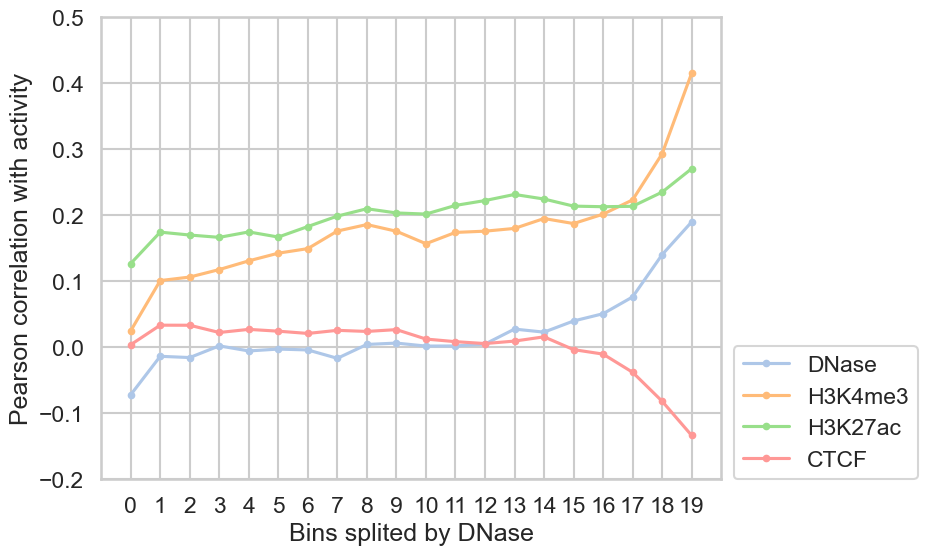

=== A549 ===
    bin  DNase  H3K4me3  H3K27ac   CTCF
0     0 -0.117    0.000   -0.097 -0.107
1     1 -0.005    0.099   -0.011 -0.004
2     2 -0.022    0.111    0.023  0.016
3     3 -0.006    0.125    0.048  0.014
4     4 -0.003    0.137    0.073  0.006
5     5 -0.000    0.141    0.082  0.001
6     6  0.002    0.131    0.070 -0.017
7     7  0.001    0.160    0.108 -0.031
8     8 -0.006    0.161    0.131 -0.035
9     9  0.022    0.130    0.116 -0.053
10   10  0.007    0.118    0.116 -0.059
11   11  0.018    0.118    0.134 -0.066
12   12 -0.001    0.124    0.136 -0.078
13   13  0.022    0.110    0.126 -0.093
14   14  0.028    0.112    0.128 -0.090
15   15  0.036    0.090    0.119 -0.113
16   16  0.046    0.092    0.100 -0.125
17   17  0.066    0.087    0.085 -0.134
18   18  0.110    0.116    0.093 -0.132
19   19  0.304    0.293    0.266 -0.081


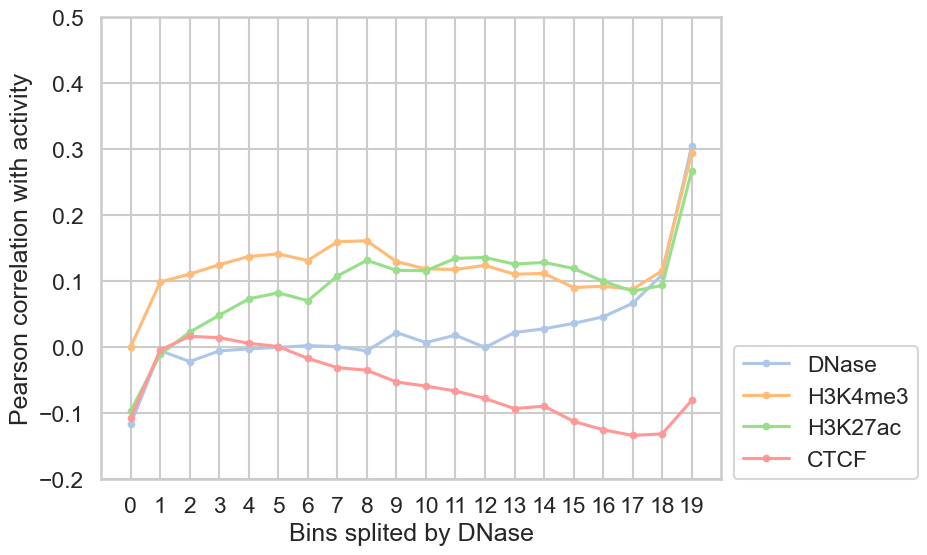

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

n_bins = 20  # 你可以根据需要调整 bin 数量

for cell_type in cell_types[:]:
    df = MPRA_df.copy()
    
    df['bin'] = pd.qcut(df[f'{cell_type}_DNase'], q=n_bins, labels=False)

    pearson_per_bin = []

    for bin_id in range(n_bins):
        bin_df = df[df['bin'] == bin_id]

        x = bin_df[f'{cell_type}_DNase']
        y = bin_df[f'{cell_type}']
        r1 = pearson(x, y)[0]

        x = bin_df[f'{cell_type}_H3K4me3']
        y = bin_df[f'{cell_type}']
        r2 = pearson(x, y)[0]

        x = bin_df[f'{cell_type}_H3K27ac']
        y = bin_df[f'{cell_type}']
        r3 = pearson(x, y)[0]

        x = bin_df[f'{cell_type}_CTCF']
        y = bin_df[f'{cell_type}']
        r4 = pearson(x, y)[0]
        pearson_per_bin.append((bin_id, r1, r2, r3, r4))


    # 转为 DataFrame 方便查看
    pearson_df = pd.DataFrame(pearson_per_bin, columns=['bin', 'DNase', 'H3K4me3', 'H3K27ac', 'CTCF'])
    print(f'=== {cell_type} ===')
    print(pearson_df)


    sns.set_theme(context='talk', style="whitegrid")
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

    for i, assay in enumerate(assays):
        plt.plot(np.arange(n_bins), pearson_df[assay], marker='.', label=assays[i], color=tab20_colors[i*2+1])

    plt.xticks(np.arange(n_bins), np.arange(n_bins))
    plt.xlabel('Bins splited by DNase')
    plt.ylabel('Pearson correlation with activity')
    plt.xlim(-1, 20)
    plt.ylim(-0.2, 0.5)

    plt.legend(bbox_to_anchor=(1.02, 0.0), loc='lower left', borderaxespad=0.)
    plt.savefig(f'figures/Gosai_MPRA_bin_activity_vs_assay_{cell_type}.png', dpi=400, bbox_inches='tight')  # 保存时也包含图例
    plt.show()


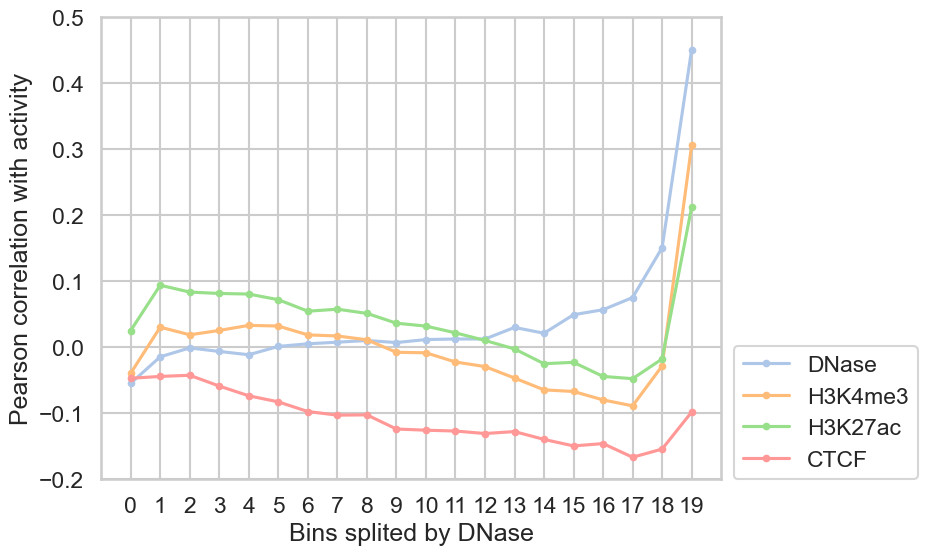

In [23]:
sns.set_theme(context='talk', style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

for i, assay in enumerate(assays):
    plt.plot(np.arange(n_bins), pearson_df[assay], marker='.', label=assays[i], color=tab20_colors[i*2+1])

plt.xticks(np.arange(n_bins), np.arange(n_bins))
plt.xlabel('Bins splited by DNase')
plt.ylabel('Pearson correlation with activity')
plt.xlim(-1, 20)
plt.ylim(-0.2, 0.5)

plt.legend(bbox_to_anchor=(1.02, 0.0), loc='lower left', borderaxespad=0.)
plt.savefig('figures/Gosai_MPRA_bin_activity_vs_assay_K562.png', dpi=400, bbox_inches='tight')  # 保存时也包含图例
plt.show()

In [54]:

n_bins = 10 # 分 bin 的数量

for i, cell_type in enumerate(['K562']):
    pearson_df = pd.DataFrame(dtype=float)
    df = MPRA_df[data_split_dict['test']]

#     # 分 bin（基于 H3K27ac）
#     bin_col = f'{cell_type}_H3K27ac_bin'
#     df[bin_col] = pd.qcut(df[f'{cell_type}_H3K27ac'], q=n_bins, labels=False, duplicates='drop')

    bin_col = f'{cell_type}_DNase_bin'
    df[bin_col] = pd.qcut(df[f'{cell_type}_DNase'], q=n_bins, labels=False, duplicates='drop')


    for bin_id in sorted(df[bin_col].dropna().unique()):
        cond = df[bin_col] == bin_id
        bin_df = df[cond]

        for j, assay in enumerate(assays):
            x = bin_df[f'{cell_type}_{assay}']
            y = bin_df[f'{cell_type}_pred']

            if len(x) > 1:
                r, _ = pearson(x, y)
            else:
                r = np.nan

            pearson_df.loc[f'bin_{bin_id}', f'{cell_type}_{assay}'] = r

    print(f'=== {cell_type} ===')
    print(pearson_df)


=== K562 ===
       K562_DNase  K562_H3K4me3  K562_H3K27ac  K562_CTCF
bin_0      -0.090        -0.045         0.024     -0.077
bin_1       0.003         0.055         0.104     -0.050
bin_2      -0.009         0.079         0.131     -0.065
bin_3       0.007         0.107         0.147     -0.073
bin_4       0.043         0.098         0.152     -0.092
bin_5       0.027         0.075         0.129     -0.101
bin_6       0.053         0.056         0.086     -0.091
bin_7       0.123         0.057         0.102     -0.102
bin_8       0.174         0.132         0.171     -0.104
bin_9       0.578         0.493         0.478      0.094


/tmp/ipykernel_31504/317376533.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[bin_col] = pd.qcut(df[f'{cell_type}_DNase'], q=n_bins, labels=False, duplicates='drop')


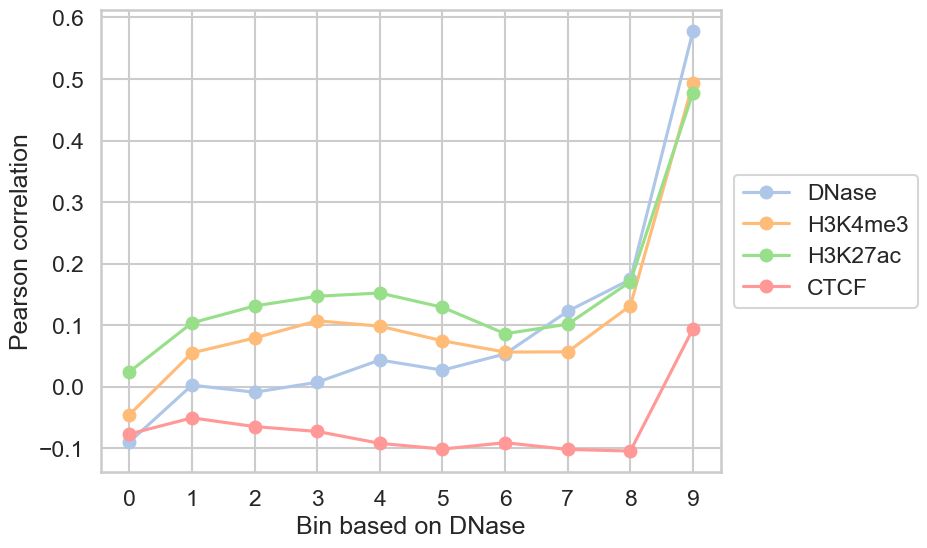

In [55]:
sns.set_theme(context='talk', style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

for i, col in enumerate(pearson_df.columns):
    plt.plot(np.arange(10), pearson_df[col], marker='o', label=assays[i], color=tab20_colors[i*2+1])

plt.xticks(np.arange(10), np.arange(10))
plt.xlabel('Bin based on DNase')
plt.ylabel('Pearson correlation')
# plt.ylim(0, 1)

# 将图例放在图外（右侧）
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0.)

plt.savefig('figures/Gosai_MPRA_bin_pred_vs_assay_corr.png', dpi=400, bbox_inches='tight')  # 保存时也包含图例
plt.show()